In [89]:
import os
import re
import glob
import time
import yaml
import numpy as np

import ase.atoms
import ase.io.gaussian
import ase.visualize

import xtb.ase.calculator

import matplotlib.pyplot as plt

In [15]:
# search my dft directories for all energy Gaussian 16 logs


# We need to save it in a format easily translatable to ase. 


# the database entries should have the following information:
# source file
# atomic numbers, xyz coordinates, charge, multiplicity
# m062x-ccpvtz energy in correct units

# maybe rmg connectivity representation about bonds? but probably not



In [4]:
DFT_dirs = [
    '/work/westgroup/harris.se/autoscience/reaction_calculator/dft'
]

In [130]:
# go crawling to fetch a list of possible gaussian files
start = time.time()
gaussian_files = []

N_TRAINING_FILES = 1000

for path, subdirs, files in os.walk(DFT_dirs[0]):
    for name in files:
        total_name = os.path.join(path, name)
        if total_name.endswith('.log') and os.path.exists(total_name[:-4] + '.com'):
            gaussian_files.append(total_name)
#             print(total_name)
    if len(gaussian_files) > N_TRAINING_FILES:
        break
#     if time.time() - start > 10:
#         break
gaussian_files = gaussian_files[:N_TRAINING_FILES]

In [131]:
def get_charge_and_multiplicity(gaussian_file):
    charge = None
    multiplicity = None
    
    with open(gaussian_file, 'r') as f:
        for i in range(500):  # give up after first 500 lines
            line = f.readline().lower()

            charge_pattern = r'charge\s*=\s*([+-]*\d+)'
            multiplicity_pattern = r'multiplicity\s*=\s*(\d+)'

            matches = re.search(charge_pattern, line)
            if matches is not None:
                charge = int(matches[1])
            matches = re.search(multiplicity_pattern, line)
            if matches is not None:
                multiplicity = int(matches[1])
            
            if charge is not None and multiplicity is not None:
                return charge, multiplicity
    
    
    return charge, multiplicity

In [132]:
# Grab each of the ase calculations from the files and run the same energy (and probable forces) calculation in xtb
# then save the results of N at a time in a yaml file

entries = []
for i in range(N_TRAINING_FILES):
    print(i)
    try:
        charge, multiplicity = get_charge_and_multiplicity(gaussian_files[i])
        with open(gaussian_files[i], 'r') as f:
            frames = ase.io.gaussian.read_gaussian_out(f, slice(None, None))
            
        for j in range(len(frames)):
            if not frames[j].calc.results or 'forces' not in frames[j].calc.results.keys():
                continue
            entry = {
                'source_file': gaussian_files[i],
                'numbers': frames[j].numbers.tolist(),
                'positions': frames[j].positions.tolist(),
                'charge': charge,
                'multiplicity': multiplicity,
                'ref_energy': frames[j].calc.results['energy'],
                'ref_forces': frames[j].calc.results['forces'].tolist(),
            }
            entries.append(entry)
    except FileNotFoundError:
        pass


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyError: 'energy'

In [133]:
len(entries)

15255

In [134]:
# might want to try different fast calculators, so maybe separate these train/calc entries
with open('my_train.yaml', 'w') as f:
    yaml.safe_dump(entries[:1000], f)

In [135]:
with open('my_train.yaml', 'r') as f:
    my_entries = yaml.safe_load(f)

In [136]:
len(my_entries)

1000

# Run Calculations Using Fast Calculator

In [143]:
calculated_energies = np.zeros(len(my_entries))
forces_list = []
for i in range(len(my_entries)):
    atoms = ase.Atoms(my_entries[i]['numbers'], my_entries[i]['positions'])
    
    atoms.calc = xtb.ase.calculator.XTB()
    calculated_energies[i] = atoms.get_potential_energy()
    forces = atoms.get_forces()
    forces_list.append(forces.tolist())
assert len(forces_list) == len(calculated_energies)
np.save('xtb_energies.npy', calculated_energies)
with open('xtb_forces.yaml', 'w') as f:
    yaml.safe_dump(forces_list, f)

# Fit a linear least squares regression model to the energy

In [145]:
with open('xtb_forces.yaml', 'r') as f:
    my_calc_forces = yaml.safe_load(f)
my_calc_energies = np.load('xtb_energies.npy')

with open('my_train.yaml', 'r') as f:
    my_entries = yaml.safe_load(f)

In [193]:
# condition the data
ref_energies = np.array([e['ref_energy'] for e in my_entries])

np.random.seed(400)


train_split = 0.6

# Shuffle the data
combined = np.vstack((ref_energies, my_calc_energies)).transpose()
np.random.shuffle(combined)
ref_energies_shuffled = combined[:, 0]
my_calc_energies_shuffled = combined[:, 1]


# pick out the train and test sets
train_test_divide = int(train_split * len(my_calc_energies_shuffled))
train_ref_energy = ref_energies_shuffled[:train_test_divide]
train_calc_energy = my_calc_energies_shuffled[:train_test_divide]
test_ref_energy = ref_energies_shuffled[train_test_divide:]
test_calc_energy = my_calc_energies_shuffled[train_test_divide:]


In [190]:
# fit a line
m, b = np.polyfit(train_calc_energy, train_ref_energy, 1)

Train MSE: 333.1323273661357
Train mean percent error: 5.28%


Text(0, 0.5, 'M06-2X Energies')

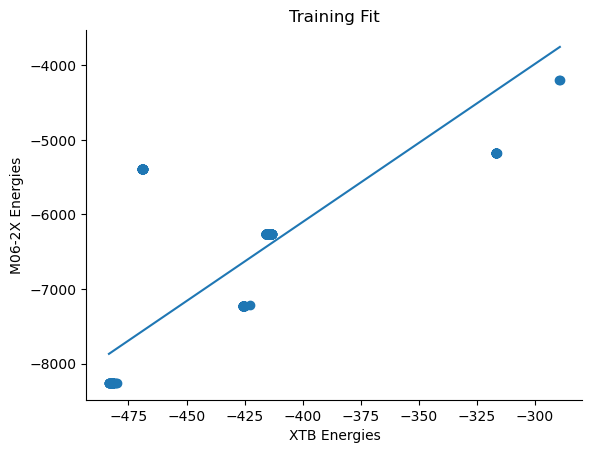

In [195]:
# plot results:
plt.scatter(train_calc_energy, train_ref_energy)

fit_energies = m * train_calc_energy + b

train_mae = np.average(np.abs(fit_energies - train_ref_energy))
train_mean_percent_error = np.average(np.abs(np.divide(fit_energies - train_ref_energy, train_ref_energy))) * 100.0

print(f'Train MSE: {train_mae}')
print(f'Train mean percent error: {train_mean_percent_error:.2f}%')

x = np.linspace(np.min(train_calc_energy), np.max(train_calc_energy), 101)
est_m06_energies = m * x + b
plt.plot(x, est_m06_energies)
plt.title('Training Fit')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('XTB Energies')
plt.ylabel('M06-2X Energies')

Test MSE: 284.6817146906767
Test mean percent error: 4.41%


Text(0, 0.5, 'M06-2X Energies')

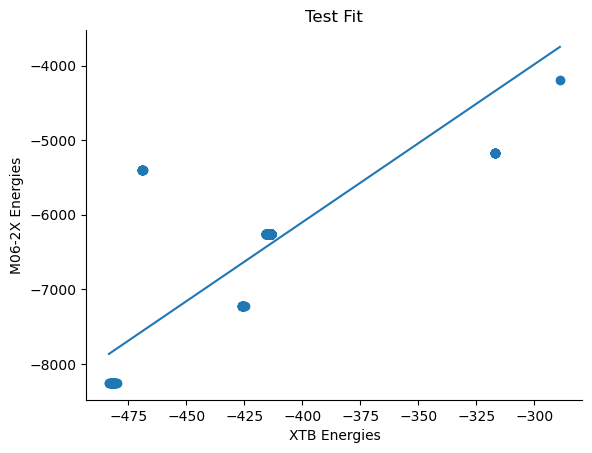

In [196]:
fit_energies = m * test_calc_energy + b
test_mae = np.average(np.abs(fit_energies - test_ref_energy))
test_mean_percent_error = np.average(np.abs(np.divide(fit_energies - test_ref_energy, test_ref_energy))) * 100.0

print(f'Test MSE: {test_mae}')
print(f'Test mean percent error: {test_mean_percent_error:.2f}%')

plt.scatter(test_calc_energy, test_ref_energy)

x = np.linspace(np.min(test_calc_energy), np.max(test_calc_energy), 101)
est_m06_energies = m * x + b
plt.plot(x, est_m06_energies)
plt.title('Test Fit')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('XTB Energies')
plt.ylabel('M06-2X Energies')